# Comparing ISO data over time

The following notebook loads two time periods of ISO data from GridStatus and compares them. 


* Is it possible to track a single project through time consistently through one ISO dataset?
* For projects that we can track over time, what changes occur? Where are projects progressing the most, and what kinds of projects have those been?
* Across the ISOs, where has there been the most activity? What kinds of projects have seen the most change over the time period?

## Part 1: Can IDs be used to compare projects over time?

### Loading the data

In [116]:
import pandas as pd
import geopandas as gpd
import pyarrow
import fastparquet
from pathlib import Path
import os
import matplotlib
from matplotlib import pyplot as plot
import numpy as np
pd.options.mode.chained_assignment = None

In [2]:
home_directory = os.path.dirname(os.getcwd())
data_folder = os.path.join(home_directory, "reports/")

In [3]:
# Configure parameters - set baseline and end date and input file names
baseline_date = "2023-07-09"
new_date = "2023-12-17"

baseline_path = os.path.join(data_folder, "iso_queues_ex_spp_isone_july9.parquet")
new_path = os.path.join(data_folder, "iso_queues_december17.parquet")

In [4]:
baseline_dataset = pd.read_parquet(baseline_path)
new_dataset = pd.read_parquet(new_path)

### Comparing project IDs across timestamps

In [5]:
# Confirm that each dataset has the same primary key
print(baseline_dataset.set_index(["queue_id", "iso_region"]).index.is_unique)
print(new_dataset.set_index(["queue_id", "iso_region"]).index.is_unique)

True
True


In [6]:
# Add date as column to enable match between ISO records
baseline_dataset['record_date'] = baseline_date
new_dataset['record_date'] = new_date

In [7]:
# NYISO has an inconsistent use of leading zeros in queue IDs between dates.
# Standardize this.
m = (baseline_dataset['queue_id'].str.isnumeric())&(baseline_dataset.iso_region=="nyiso")
baseline_dataset.loc[m, 'queue_id'] = baseline_dataset.loc[m, 'queue_id'].str.lstrip('0')


In [8]:
# Check this works as expected
baseline_dataset[["queue_id", "iso_region"]]

queue_id iso_region
0       J1204       miso
1       J1216       miso
2       J1221       miso
3       J1262       miso
4       J1295       miso
...       ...        ...
6365     1565      nyiso
6366     1566      nyiso
6367     1569      nyiso
6368     1573      nyiso
6369     1574      nyiso

[6370 rows x 2 columns]

In [9]:
# Merge datasets
merged_data = baseline_dataset.merge(new_dataset, how = "outer", indicator=True, on=['queue_id', 'iso_region'])

In [10]:
# At a high level, how well did this work?
# Right only is the new dataset, while left_only is the baseline dataset
merged_data._merge.value_counts()

_merge
both          5880
right_only    1289
left_only      490
Name: count, dtype: int64

In [11]:
baseline_dataset.loc[0]

project_id                                              0
actual_completion_date                                NaT
capacity_mw                                         199.3
county                                  Cumberland County
resource                                            Solar
interconnecting_entity                               <NA>
point_of_interconnection      Casey West 345kV Substation
project_name                                         <NA>
proposed_completion_date                              NaT
queue_date                            2019-04-26 04:00:00
queue_id                                            J1204
state                                                  IL
queue_status                                       active
summer_capacity_mw                                  199.3
transmission_owner                        Ameren Illinois
winter_capacity_mw                                  199.3
withdrawal_comment                                   <NA>
withdrawn_date

In [12]:
# Do the same IDs likely refer to the same projects over time?
state_change = merged_data[(merged_data._merge == "both") & (merged_data.state_x != merged_data.state_y)]
queue_change = merged_data[(merged_data._merge == "both") & (merged_data.queue_date_x != merged_data.queue_date_y)]
resource_change = merged_data[(merged_data._merge == "both") & (merged_data.resource_clean_x != merged_data.resource_clean_y)]
county_change = merged_data[(merged_data._merge == "both") & (merged_data.county_id_fips_x != merged_data.county_id_fips_y)]
matches = len(merged_data[merged_data._merge == "both"])

print(f"State changed: {len(state_change)/matches:.2%}.\nQueue date changed: {len(queue_change)/matches:.2%}.\nResource type changed: {len(resource_change)/matches:.2%}.\nCounty FIPS ID changed: {len(county_change)/matches:.2%}.")

State changed: 0.03%.
Queue date changed: 1.09%.
Resource type changed: 0.05%.
County FIPS ID changed: 0.61%.


In [13]:
# Inspect a dataframe of possible mismatches
df = county_change
df.iloc[0]
df.reindex(sorted(df.columns), axis=1).head(10)

_merge actual_completion_date_x actual_completion_date_y  capacity_mw_x  \
68    both                      NaT                      NaT          200.0   
84    both                      NaT                      NaT           80.0   
133   both                      NaT                      NaT          200.0   
220   both                      NaT                      NaT          100.0   
243   both                      NaT                      NaT          220.0   
245   both                      NaT                      NaT          165.0   
275   both                      NaT                      NaT          150.0   
314   both                      NaT                      NaT          200.0   
344   both                      NaT                      NaT          300.0   
542   both                      NaT                      NaT          200.0   

     capacity_mw_y county_id_fips_x county_id_fips_y    county_x    county_y  \
68           200.0            19037            19089   Chickasaw      Howard   
84            80.0            22019            22011   Calcasieu  Beauregard   
133          200.0            17115            17173       Macon      Shelby   
220          100.0            26155            26093  Shiawassee  Livingston   
243          220.0            22051            22007   Jefferson  Assumption   
245          165.0            22051            22007   Jefferson  Assumption   
275          150.0            28133            28011   Sunflower     Bolivar   
314          200.0            17167            17137    Sangamon      Morgan   
344          300.0            55049            55065        Iowa   Lafayette   
542          200.0            27063            27165     Jackson    Watonwan   

    geocoded_containing_county_x  ... summer_capacity_mw_x  \
68                     Chickasaw  ...                200.0   
84                     Calcasieu  ...                 80.0   
133                        Macon  ...                200.0   
220                   Shiawassee  ...                100.0   
243                    Jefferson  ...                220.0   
245                    Jefferson  ...                165.0   
275                    Sunflower  ...                150.0   
314                     Sangamon  ...                200.0   
344                         Iowa  ...                300.0   
542                      Jackson  ...                200.0   

    summer_capacity_mw_y                     transmission_owner_x  \
68                 200.0                              ITC Midwest   
84                  80.0                        CLECO Corporation   
133                200.0                          Ameren Illinois   
220                100.0                         ITC Transmission   
243                220.0                   Entergy Louisiana, LLC   
245                165.0                   Entergy Louisiana, LLC   
275                150.0                                            
314                200.0  Ameren Transmission Company of Illinois   
344                300.0            American Transmission Co. LLC   
542                200.0      Northern States Power (Xcel Energy)   

    transmission_owner_y winter_capacity_mw_x winter_capacity_mw_y  \
68                                      200.0                200.0   
84                                       80.0                 80.0   
133                                     200.0                200.0   
220                                     100.0                100.0   
243                                     220.0                220.0   
245                                     165.0                165.0   
275                                     150.0                150.0   
314                                     200.0                200.0   
344                                     300.0                300.0   
542                                     200.0                200.0   

    withdrawal_comment_x  withdrawal_co

Which records don't match, and why?

In [14]:
# How many records don't match because they were added to the queue after the baseline date?
added_after_baseline = merged_data[(merged_data._merge == "right_only") & (merged_data.queue_date_y > baseline_date)]

In [15]:
right_only = merged_data[(merged_data._merge == "right_only") & (merged_data.queue_date_y < baseline_date)].set_index(['queue_id', 'iso_region'])
left_only = merged_data[(merged_data._merge == "left_only")].set_index(['queue_id', 'iso_region'])

right_only_data = new_dataset.set_index(['queue_id', 'iso_region']).loc[right_only.index, :].reset_index()
left_only_data = baseline_dataset.set_index(['queue_id', 'iso_region']).loc[left_only.index, :].reset_index()

In [16]:
county_name_match = left_only_data.merge(right_only_data, on = ['project_name', 'county_id_fips']).dropna(subset = ['project_name', 'county_id_fips'])
resource_capacity_match = left_only_data.merge(right_only_data, on = ['capacity_mw', 'resource_clean', 'county_id_fips']).dropna(subset = ['capacity_mw', 'resource_clean', 'county_id_fips'])
completion_date_match = left_only_data.merge(right_only_data, on = ['proposed_completion_date', 'county_id_fips']).dropna(subset = ['proposed_completion_date', 'county_id_fips'])

failed_matches = merged_data[(merged_data._merge != "both") & ~(merged_data.queue_date_y > baseline_date)]
print(f"Percentage of unmatched records where ID and ISO are not a match but the following are:\nCounty FIPS and project name: {len(county_name_match)/(len(failed_matches)):.2%}\nResource, capacity and county FIPS: {len(resource_capacity_match)/(len(failed_matches)):.2%}\nProposed completion date and county FIPS: {len(completion_date_match)/(len(failed_matches)):.2%}")

Percentage of unmatched records where ID and ISO are not a match but the following are:
County FIPS and project name: 0.00%
Resource, capacity and county FIPS: 0.00%
Proposed completion date and county FIPS: 0.15%


In [17]:
# Are there any particularly problematic ISOs?
failed_matches.iso_region.value_counts()

iso_region
isone    396
spp      347
pjm      297
ercot    166
miso      63
nyiso     54
caiso     10
Name: count, dtype: Int64

In [18]:
failed_matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1333 entries, 5 to 7653
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   project_id_x                  490 non-null    Int64         
 1   actual_completion_date_x      0 non-null      datetime64[us]
 2   capacity_mw_x                 481 non-null    float64       
 3   county_x                      482 non-null    string        
 4   resource_x                    475 non-null    string        
 5   interconnecting_entity_x      109 non-null    string        
 6   point_of_interconnection_x    174 non-null    string        
 7   project_name_x                431 non-null    string        
 8   proposed_completion_date_x    146 non-null    datetime64[us]
 9   queue_date_x                  490 non-null    datetime64[us]
 10  queue_id                      1333 non-null   string        
 11  state_x                       482 n

### Conclusions on ID matching.

Matching on ``queue_id`` and ``iso_region`` seems to be a relatively robust way to compare ISO data over time. Comparing Dec and July data, we see relatively low (~<1%) changes in immutable project characteristics between matched projects, and projects that remain unmatched don't seem to share key observed characteristics with one another. Attention is required to leading zeros or other format changes for each ISO's IDs.

## Part 2: Assessing per-project changes over time
How much do individual projects progress over time? This section of the analysis will focus on projects with both baseline and new data, tracking changes in status at the project level for projects that have the same ``queue_id`` and ``iso_region`` in both datasets.

In [19]:
changes = merged_data[merged_data._merge == "both"]
print(f"{len(changes)/len(merged_data):.2%} of all projects in both datasets appear in both the baseline and new dataset.")

76.77% of all projects in both datasets appear in both the baseline and new dataset.


In [20]:
certainty_change = changes[changes.is_nearly_certain_x != changes.is_nearly_certain_y]
actionable_change = changes[changes.is_actionable_x != changes.is_actionable_y]
# Because we only filter for active projects, the change in withdrawn date should be none, but let's check this to be sure.
withdrawn_change = changes[(changes.withdrawn_date_x != changes.withdrawn_date_y)&(changes.withdrawn_date_x.notnull())&(changes.withdrawn_date_y.notnull())]
assert len(withdrawn_change)==0

changes.loc[:,'certainty_change'] = changes['is_nearly_certain_y'].astype(int) - changes['is_nearly_certain_x'].astype(int)
changes.loc[:,'actionability_change'] = changes['is_actionable_y'].astype(int) - changes['is_actionable_x'].astype(int)

print(f"Of these {len(changes)} projects, {len(certainty_change)} ({len(certainty_change)/len(changes):.2%}) have a change in approval, and {len(actionable_change)} ({len(actionable_change)/len(changes):.2%}) have a difference in 'actionability'.")
print(f"{len(changes[changes.certainty_change>0])} projects became more certain and {len(changes[changes.certainty_change<0])} became less certain.")
print(f"{len(changes[changes.actionability_change>0])} projects became more actionable and {len(changes[changes.actionability_change<0])} became less actionable.")

Of these 5880 projects, 21 (0.36%) have a change in approval, and 185 (3.15%) have a difference in 'actionability'.
21 projects became more certain and 0 became less certain.
114 projects became more actionable and 71 became less actionable.


Where do changes in project certainty and actionability occur? We use 2023 Census shapefiles to map these changes to the county level. (Loading them in will take a moment.)

In [21]:
state_outlines = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/STATE/tl_rd22_us_state.zip")
county_shapes = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/COUNTY/tl_rd22_us_county.zip")

In [22]:
county_shapes['county_id_fips'] = county_shapes['STATEFP']+county_shapes['COUNTYFP'] # Add 5 digit FIPS column
state_plot = state_outlines[(state_outlines.STATEFP.astype(int)<60)&~(state_outlines.STATEFP.isin(["02", "15"]))]

changes_sp = county_shapes.merge(changes, left_on = "county_id_fips", right_on="county_id_fips_x")

In [23]:
agg_changes = changes_sp[['county_id_fips', 'actionability_change', 'certainty_change', 'geometry']]
agg_actionable = agg_changes.dissolve(by='county_id_fips', aggfunc='sum')

<Axes: title={'center': 'Aggregate change in number of actionable projects by county'}>

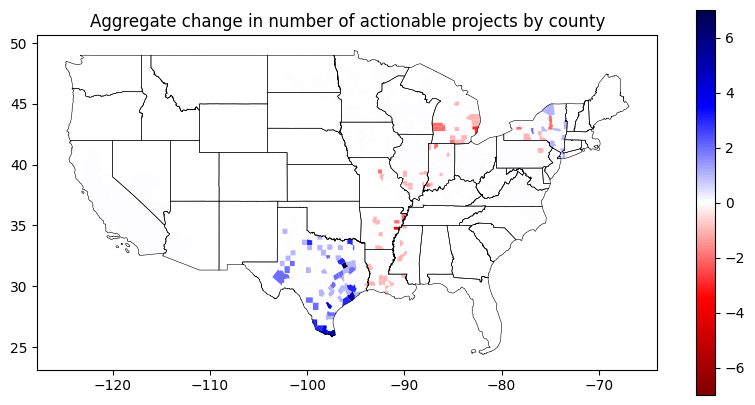

In [24]:
fig, ax = plot.subplots(figsize = (10,5))
ax.set_title("Per project aggregate changes in actionability by county")
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-7, vcenter=0, vmax=7) # Force 0 to be center of scale
base = agg_actionable.plot(ax = ax, column="actionability_change", cmap = "seismic_r", norm=divnorm, legend = True)
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)

<Axes: title={'center': 'Aggregate change in number of certain projects by county'}>

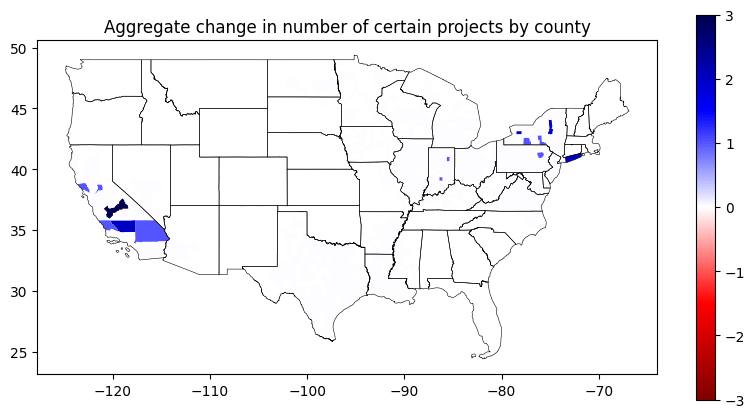

In [25]:
fig, ax = plot.subplots(figsize = (10,5))
ax.set_title("Per project aggregate certainty changes by county")
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3) # Force 0 to be center of scale
base = agg_actionable.plot(ax = ax, column="certainty_change", cmap = "seismic_r", norm=divnorm, legend = True)
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)

How do proposed project completion dates change over time? Where are projects getting postponed the furthest?

In [26]:
changes_sp['project_date_change'] = changes_sp['proposed_completion_date_y'] - changes_sp['proposed_completion_date_x']
date_change = changes_sp.loc[changes_sp.project_date_change.notnull(), ['project_date_change', 'geometry', 'county_id_fips']]
agg_date_change = date_change.dissolve(by='county_id_fips', aggfunc='mean') # Aggregate by county
agg_date_change['project_date_change'] = agg_date_change['project_date_change'].dt.days/365 # Get date change in terms of years

<Axes: title={'center': 'Per county average change in project completion date (in years)'}>

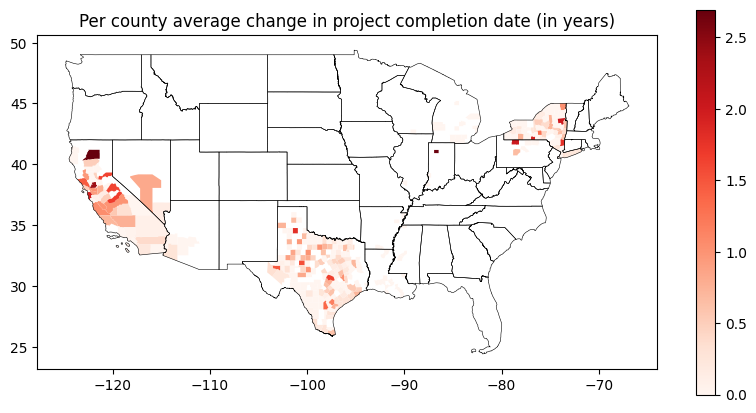

In [27]:
fig, ax = plot.subplots(figsize = (10,5))
ax.set_title("Per county average change in project completion date (in years)")
base = agg_date_change.plot(ax = ax, column="project_date_change", cmap = "Reds", legend = True) # To update
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)

## Part 3: Assessing overall changes over time
Comparing the baseline and new data, how does the overall project landscape change over the time interval? How do the number of projects, their type, size and status change over the time period examined?

What counties have added the most projects to the queue over the time period?

In [28]:
baseline_projects = baseline_dataset.groupby('county_id_fips').size().reset_index() # Get number of projects per county
new_projects = new_dataset.groupby('county_id_fips').size().reset_index()
change_projects = baseline_projects.merge(new_projects, on = "county_id_fips", how = "outer", suffixes = ("_baseline", "_new"), validate = "1:1") 
change_projects = change_projects.fillna(0)
change_projects['change_projects'] = change_projects['0_new'] - change_projects['0_baseline']
change_projects_sp = county_shapes.merge(change_projects, left_on = "county_id_fips", right_on="county_id_fips")

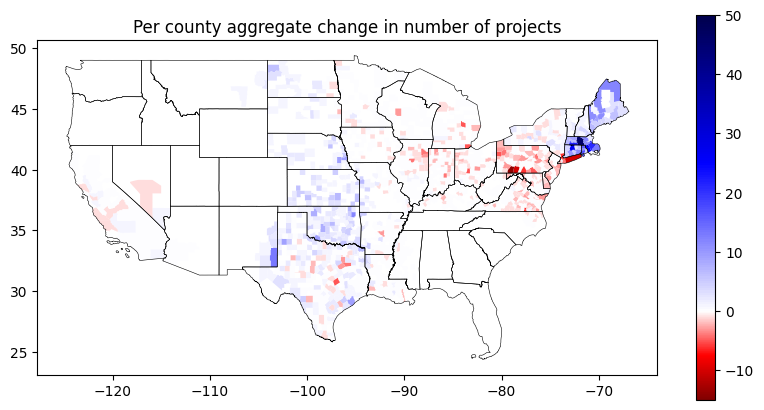

In [51]:
fig, ax = plot.subplots(figsize = (10,5))
ax.set_title("Per county aggregate change in number of projects")
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-15, vcenter=0, vmax=50) # Force 0 to be center of scale
base = change_projects_sp.plot(ax = ax, column="change_projects", cmap = "seismic_r", norm = divnorm, legend = True) # To update
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)
cb_ax = fig.axes[1] # Get colorbar
cb_ax.set_yscale('linear') # Set to be linear

Note that because projects are only in the processed dataset if they are "active" in the queue, the potential causes for decreases in project numbers include project completion, projects moving to a different location, _or_ project abandonment. Without integration of other project statuses into data processing this could be inferred through the baseline proposed completion date, but cannot be confirmed directly without consulting other data sources.

How many projects have been added or removed from the queue by each type of resource?

In [30]:
baseline_resources = baseline_dataset.groupby(['county_id_fips', 'resource_clean']).size().reset_index() # Get number of projects per county
new_resources = new_dataset.groupby(['county_id_fips', 'resource_clean']).size().reset_index()
change_resources = baseline_resources.merge(new_resources, on = ["county_id_fips", 'resource_clean'], how = "outer", suffixes = ("_baseline", "_new"), validate = "1:1") 
change_resources = change_resources.fillna(0)
change_resources['change_resources'] = change_resources['0_new'] - change_resources['0_baseline']
change_resources_sp = county_shapes.merge(change_resources, left_on = "county_id_fips", right_on="county_id_fips")

In [79]:
change_agg = change_resources.groupby('resource_clean')[['0_baseline','change_resources']].sum().reset_index()
change_agg['percent_change'] = change_agg['change_resources']/change_agg['0_baseline']
print("Percentage change in number of projects by resource type:")
print(change_agg.set_index('resource_clean').sort_values(['percent_change'])['percent_change'].map('{:.2%}'.format))


Percentage change in number of projects by resource type:
resource_clean
Transmission       -38.10%
Offshore Wind      -14.63%
Hydro               -7.69%
Biomass              0.00%
Coal                 0.00%
Solar                8.17%
Other               10.00%
Unknown             11.50%
Battery Storage     16.44%
Onshore Wind        28.61%
Natural Gas         32.00%
Steam               50.00%
Oil                100.00%
Fuel Cell             inf%
Name: percent_change, dtype: object


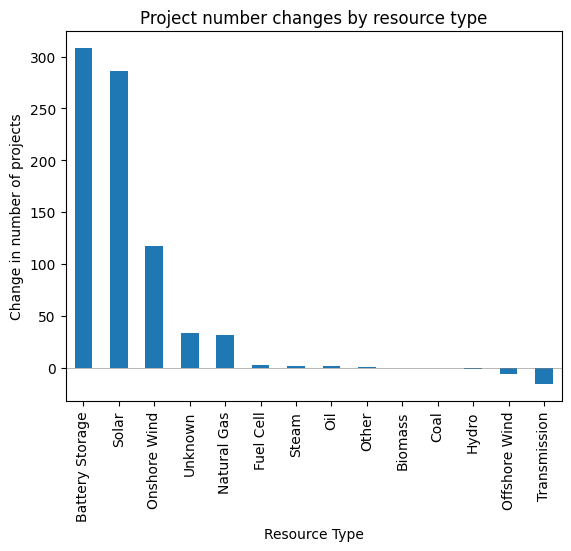

In [80]:
ax = change_agg.sort_values('change_resources', ascending = False).plot.bar(x = "resource_clean", y = "change_resources", legend = False, title = "Project number changes by resource type", xlabel="Resource Type", ylabel="Change in number of projects")
ax.axhline(y=0, xmin=-1, xmax=1, color='grey', linestyle='-', lw=0.4)

How are these changes distributed across the US?

In [32]:
change_resources_filt = change_resources_sp.groupby('resource_clean').filter(lambda x: (x['change_resources'] != 0).any()).reset_index() 
resources = change_resources_filt.resource_clean.unique()

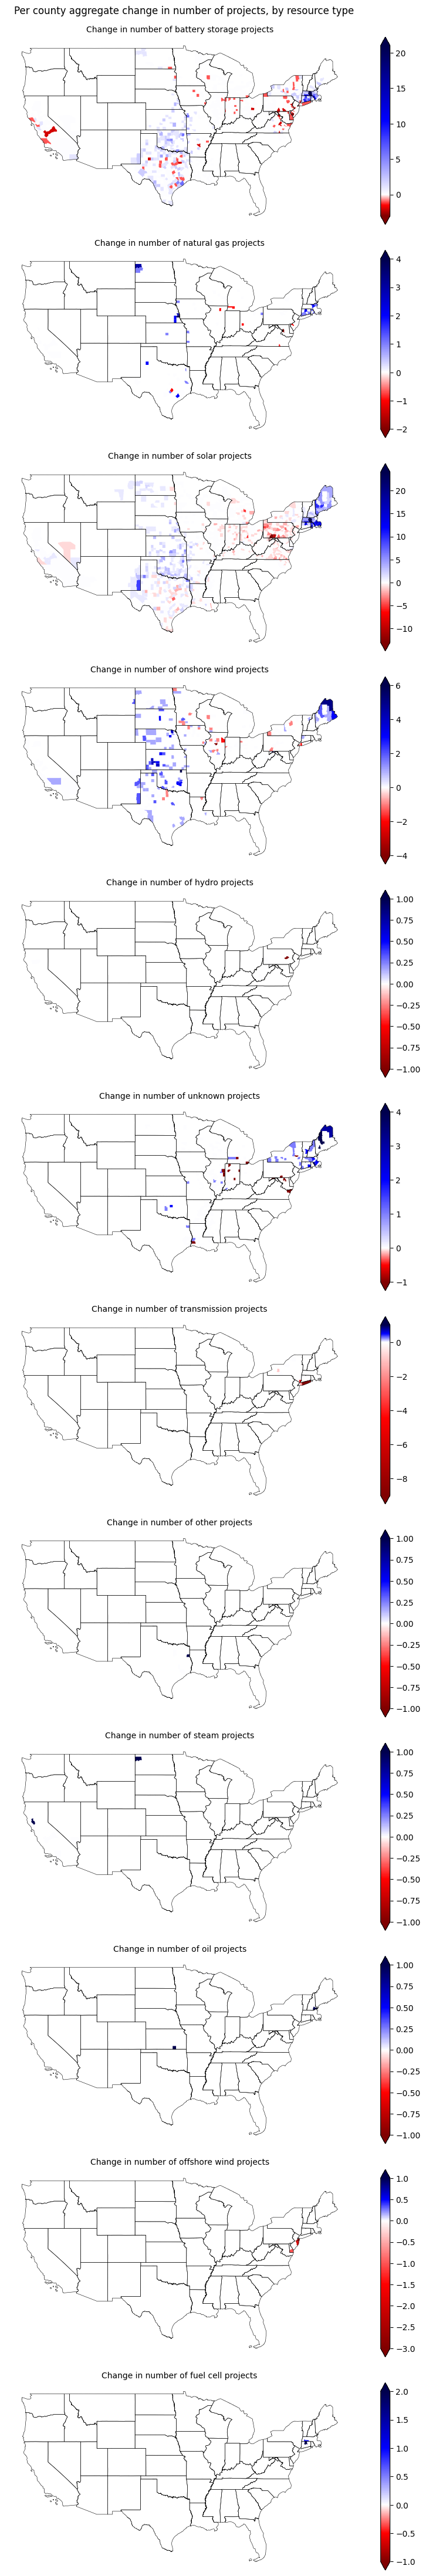

In [33]:
fig, ax = plot.subplots(len(resources), 1, figsize = (10, 45))
fig.suptitle("Per county aggregate change in number of projects, by resource type", ha="center")
fig.tight_layout(rect=[0, 0, 1, 0.98]) # Make room for suptitle
for i, resource in enumerate(resources):
    resource_slice = change_resources_filt[change_resources_filt.resource_clean==resource]
    if any(resource_slice.change_resources!=0): # If any change in category
        vmin = resource_slice.change_resources.min() if resource_slice.change_resources.min() < 0 else -1 # If no projects lost, set to -1
        vmax = resource_slice.change_resources.max() if resource_slice.change_resources.max() > 0 else 1 # If no projects gained, set to 1
        norm = matplotlib.colors.TwoSlopeNorm(vmin = vmin, vcenter=0, vmax=vmax)
        resource_slice.plot(ax = ax[i], column="change_resources", cmap = "seismic_r", norm = norm, legend = True, legend_kwds={"extend":"both"}) # To update
        state_plot.boundary.plot(ax = ax[i], edgecolor="black", linewidth = 0.4)
        ax[i].set_title(f"Change in number of {resource.lower()} projects", size = 10)
        ax[i].set_axis_off()
        cb_ax = fig.axes[i+len(resources)] # Get colorbar
        cb_ax.set_yscale('linear') # Set to be linear


What about changes in capacity by resource type?

In [34]:
baseline_capacity = baseline_dataset.groupby(['county_id_fips', 'resource_clean'])['capacity_mw'].sum().reset_index() # Get number of projects per county
new_capacity = new_dataset.groupby(['county_id_fips', 'resource_clean'])['capacity_mw'].sum().reset_index()
change_capacity = baseline_capacity.merge(new_capacity, on = ["county_id_fips", 'resource_clean'], how = "outer", suffixes = ("_baseline", "_new"), validate = "1:1") 
change_capacity = change_capacity.fillna(0)
change_capacity['change_capacity'] = change_capacity['capacity_mw_new'] - change_capacity['capacity_mw_baseline']
change_capacity_sp = county_shapes.merge(change_capacity, left_on = "county_id_fips", right_on="county_id_fips")

In [119]:
change_capacity_all = change_capacity.groupby('resource_clean')[['capacity_mw_baseline','change_capacity']].sum().reset_index()
change_capacity_all['percent_change'] = change_capacity_all['change_capacity'] / change_capacity_all['capacity_mw_baseline']
print("Percentage change in capacity by resource type:")
print(change_capacity_all[np.isfinite(change_capacity_all.percent_change)].set_index('resource_clean').sort_values(['percent_change'])['percent_change'].map('{:.2%}'.format))

Percentage change in capacity by resource type:
resource_clean
Hydro              -57.24%
Transmission       -21.16%
Offshore Wind      -13.61%
Coal                 0.00%
Biomass              0.00%
Solar               12.19%
Onshore Wind        18.07%
Battery Storage     20.48%
Unknown             23.91%
Natural Gas         27.79%
Steam               35.52%
Other               82.21%
Oil                241.86%
Name: percent_change, dtype: object


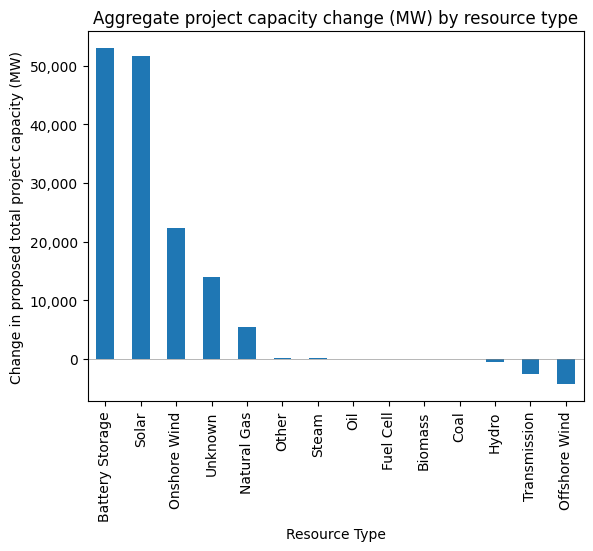

In [35]:
ax = change_capacity.groupby('resource_clean')['change_capacity'].sum().reset_index().sort_values('change_capacity', ascending = False).plot.bar(x = "resource_clean", legend = False, title = "Aggregate project capacity change (MW) by resource type", xlabel="Resource Type", ylabel="Change in proposed total project capacity (MW)")
ax.axhline(y=0, xmin=-1, xmax=1, color='grey', linestyle='-', lw=0.4)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

In [36]:
change_capacity_filt = change_capacity_sp.groupby('resource_clean').filter(lambda x: (x['change_capacity'] != 0).any()).reset_index() 
resources = change_capacity_filt.resource_clean.unique()

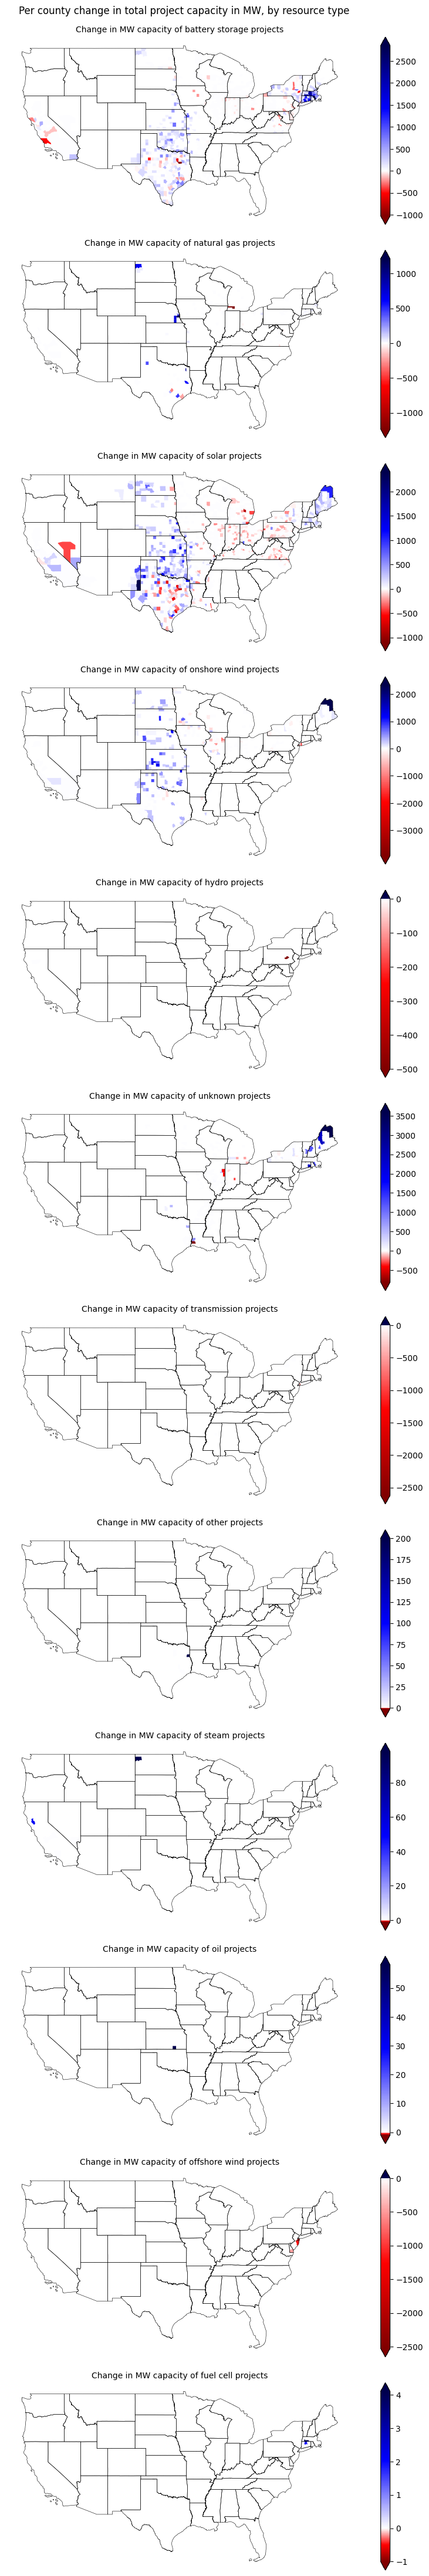

In [37]:
fig, ax = plot.subplots(len(resources), 1, figsize = (10, 45))
fig.suptitle("Per county change in total project capacity in MW, by resource type", ha="center")
fig.tight_layout(rect=[0, 0, 1, 0.98]) # Make room for suptitle
for i, resource in enumerate(resources):
    resource_slice = change_capacity_filt[change_capacity_filt.resource_clean==resource]
    if any(resource_slice.change_capacity!=0): # If any change in category
        vmin = resource_slice.change_capacity.min() if resource_slice.change_capacity.min() < 0 else -1 # If no projects lost, set to -1
        vmax = resource_slice.change_capacity.max() if resource_slice.change_capacity.max() > 0 else 1 # If no projects gained, set to 1
        norm = matplotlib.colors.TwoSlopeNorm(vmin = vmin, vcenter=0, vmax=vmax)
        resource_slice.plot(ax = ax[i], column="change_capacity", cmap = "seismic_r", norm = norm, legend = True, legend_kwds={"extend":"both"}) # To update
        state_plot.boundary.plot(ax = ax[i], edgecolor="black", linewidth = 0.4)
        ax[i].set_title(f"Change in MW capacity of {resource.lower()} projects", size = 10)
        ax[i].set_axis_off()
        cb_ax = fig.axes[i+len(resources)] # Get colorbar
        cb_ax.set_yscale('linear') # Set to be linear
        

Where are changes in 'actionable' and 'nearly certain' projects occurring?

In [38]:
baseline_actionable = baseline_dataset.groupby(['county_id_fips', 'resource_clean'])['is_actionable'].sum().reset_index()
new_actionable = new_dataset.groupby(['county_id_fips', 'resource_clean'])['is_actionable'].sum().reset_index()
change_actionable = baseline_actionable.merge(new_actionable, on = ["county_id_fips", 'resource_clean'], how = "outer", suffixes = ("_baseline", "_new"), validate = "1:1") 
change_actionable = change_actionable.fillna(0)
change_actionable['change_actionable'] = change_actionable['is_actionable_new'] - change_actionable['is_actionable_baseline']
change_actionable_sp = county_shapes.merge(change_actionable, left_on = "county_id_fips", right_on="county_id_fips")

In [96]:
change_actionable_all = change_actionable_sp[['county_id_fips', 'is_actionable_baseline', 'change_actionable','geometry']].dissolve(by='county_id_fips', aggfunc='sum').reset_index() # Aggregate by county
change_actionable_all['change_actionable'] = change_actionable_all['change_actionable'].astype(int) # Fix error by forcing dtype to int

<Axes: title={'center': 'Aggregate change in number of actionable projects by county'}>

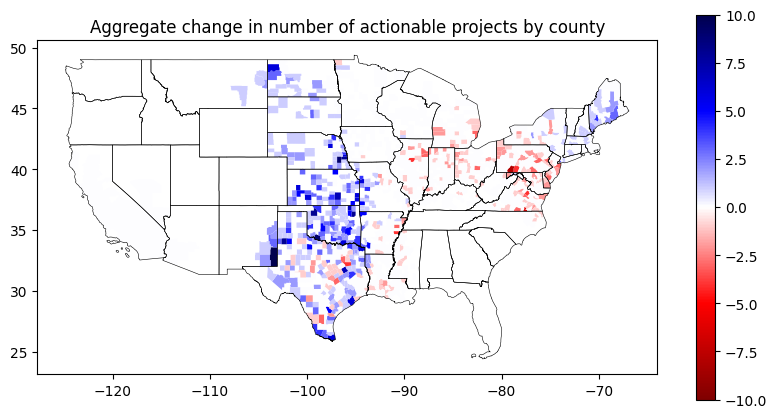

In [40]:
fig, ax = plot.subplots(figsize = (10,5))
ax.set_title("Aggregate change in number of actionable projects by county")
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10) # Force 0 to be center of scale
change_actionable_all.plot(ax = ax, column="change_actionable", cmap = "seismic_r", norm = divnorm, legend = True) # To update
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)

What changes in project actionability are observed by project type?

In [118]:
change_actionable_sum = change_actionable.groupby('resource_clean')[['is_actionable_baseline','change_actionable']].sum().reset_index()
change_actionable_sum['percent_change'] = change_actionable_sum['change_actionable'] / change_actionable_sum['is_actionable_baseline']
print("Percentage change in actionability by resource type:")
print(change_actionable_sum[np.isfinite(change_actionable_sum.percent_change)].set_index('resource_clean').sort_values(['percent_change'])['percent_change'].map('{:.2%}'.format))

Percentage change in actionability by resource type:
resource_clean
Hydro              -50.00%
Offshore Wind      -42.86%
Unknown            -20.00%
Biomass              0.00%
Solar               13.51%
Transmission        16.67%
Battery Storage     23.98%
Other               25.00%
Natural Gas         55.00%
Onshore Wind       106.25%
Name: percent_change, dtype: object


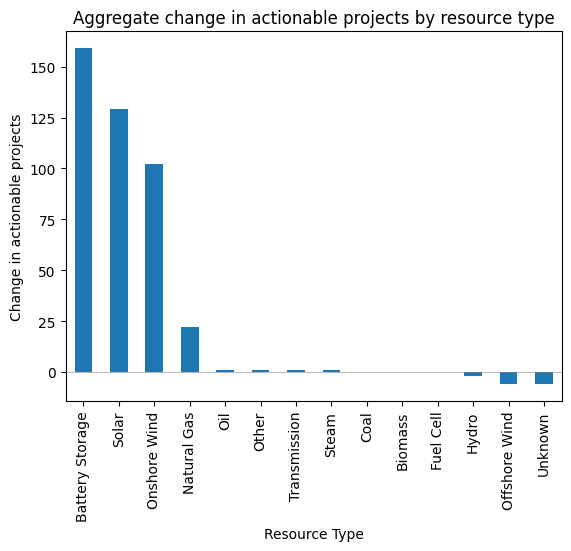

In [104]:
ax = change_actionable_sum.reset_index().sort_values('change_actionable', ascending = False).plot.bar(x = "resource_clean", y="change_actionable", legend = False, title = "Aggregate change in actionable projects by resource type", xlabel="Resource Type", ylabel="Change in actionable projects")
ax.axhline(y=0, xmin=-1, xmax=1, color='grey', linestyle='-', lw=0.4)

In [42]:
change_actionable_filt = change_actionable_sp.groupby('resource_clean').filter(lambda x: (x['change_actionable'] != 0).any()).reset_index() 
resources = change_actionable_filt.resource_clean.unique()
change_actionable_filt['change_actionable'] = change_actionable_filt['change_actionable'].astype(int)

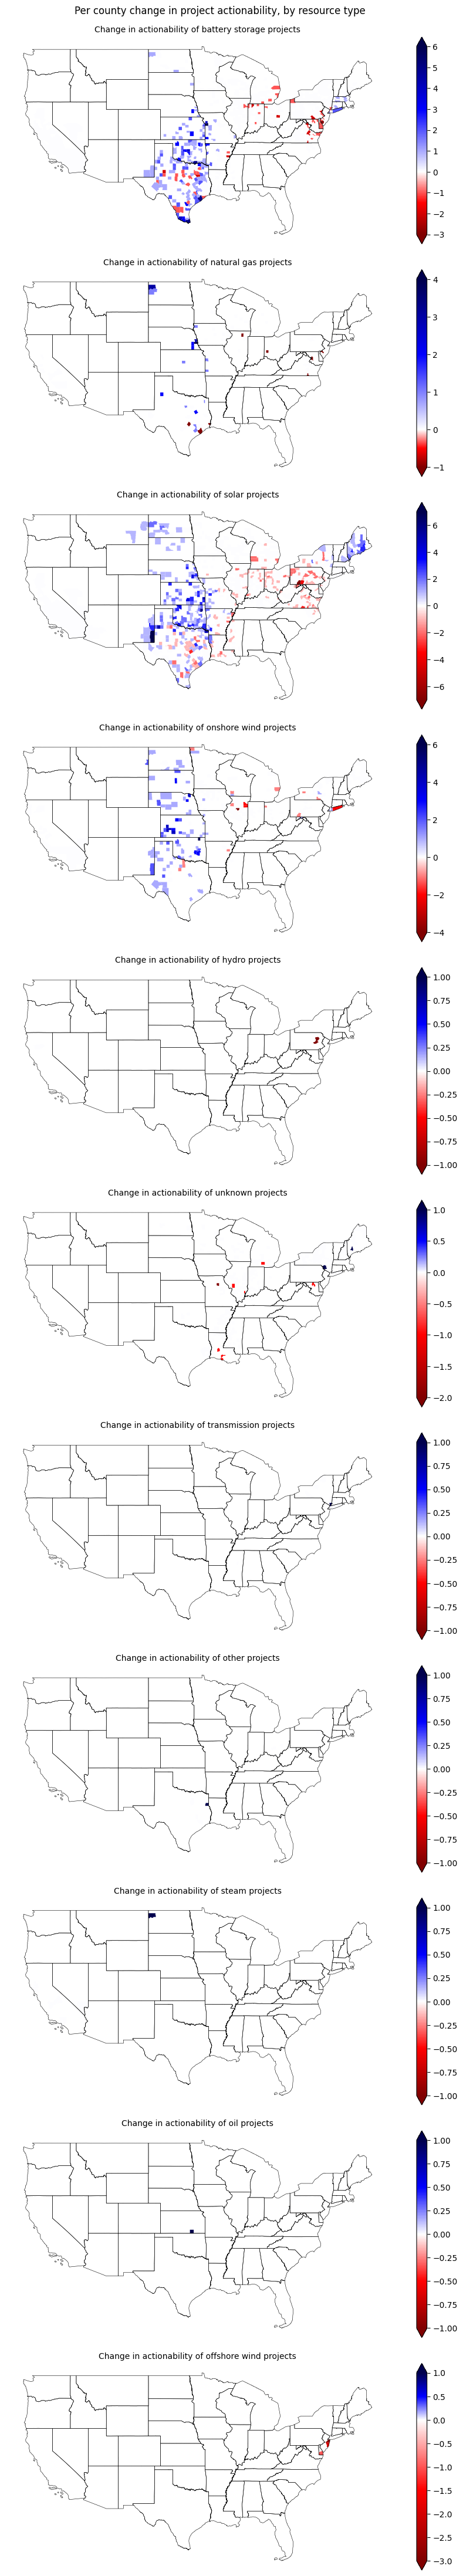

In [43]:
fig, ax = plot.subplots(len(resources), 1, figsize = (10, 45))
fig.suptitle("Per county change in project actionability, by resource type", ha="center")
fig.tight_layout(rect=[0, 0, 1, 0.98]) # Make room for suptitle
for i, resource in enumerate(resources):
    resource_slice = change_actionable_filt[change_actionable_filt.resource_clean==resource]
    if any(resource_slice.change_actionable!=0): # If any change in category
        vmin = resource_slice.change_actionable.min() if resource_slice.change_actionable.min() < 0 else -1 # If no projects lost, set to -1
        vmax = resource_slice.change_actionable.max() if resource_slice.change_actionable.max() > 0 else 1 # If no projects gained, set to 1
        norm = matplotlib.colors.TwoSlopeNorm(vmin = vmin, vcenter=0, vmax=vmax)
        resource_slice.plot(ax = ax[i], column="change_actionable", cmap = "seismic_r", norm = norm, legend = True, legend_kwds={"extend":"both"}) # To update
        state_plot.boundary.plot(ax = ax[i], edgecolor="black", linewidth = 0.4)
        ax[i].set_title(f"Change in actionability of {resource.lower()} projects", size = 10)
        ax[i].set_axis_off()
        cb_ax = fig.axes[i+len(resources)] # Get colorbar
        cb_ax.set_yscale('linear') # Set to be linear
        

Where are changes in 'nearly certain' projects occuring?

In [44]:
baseline_certainty = baseline_dataset.groupby(['county_id_fips', 'resource_clean'])['is_nearly_certain'].sum().reset_index()
new_certainty = new_dataset.groupby(['county_id_fips', 'resource_clean'])['is_nearly_certain'].sum().reset_index()
change_certainty = baseline_certainty.merge(new_certainty, on = ["county_id_fips", 'resource_clean'], how = "outer", suffixes = ("_baseline", "_new"), validate = "1:1") 
change_certainty = change_certainty.fillna(0)
change_certainty['change_certainty'] = change_certainty['is_nearly_certain_new'] - change_certainty['is_nearly_certain_baseline']
change_certainty_sp = county_shapes.merge(change_certainty, left_on = "county_id_fips", right_on="county_id_fips")

In [45]:
change_certainty_all = change_certainty_sp[['county_id_fips', 'change_certainty','geometry']].dissolve(by='county_id_fips', aggfunc='sum').reset_index() # Aggregate by county
change_certainty_all['change_certainty'] = change_certainty_all['change_certainty'].astype(int) # Fix error by forcing dtype to int

<Axes: title={'center': 'Aggregate change in number of nearly certain projects by county'}>

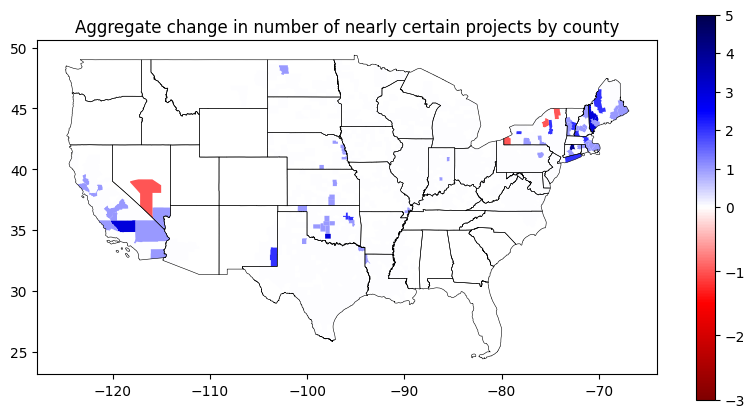

In [46]:
fig, ax = plot.subplots(figsize = (10,5))
ax.set_title("Aggregate change in number of nearly certain projects by county")
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=5) # Force 0 to be center of scale
change_certainty_all.plot(ax = ax, column="change_certainty", cmap = "seismic_r", norm = divnorm, legend = True) # To update
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)

How are these changes distributed across the US?

In [117]:
change_certainty_sum = change_certainty.groupby('resource_clean')[['is_nearly_certain_baseline','change_certainty']].sum().reset_index()
change_certainty_sum['percent_change'] = change_certainty_sum['change_certainty'] / change_certainty_sum['is_nearly_certain_baseline']
print("Percentage change in nearly certain projects by resource type:")
print(change_certainty_sum.loc[np.isfinite(change_certainty_sum.percent_change)].set_index('resource_clean').sort_values(['percent_change'])['percent_change'].map('{:.2%}'.format))

Percentage change in nearly certain projects by resource type:
resource_clean
Transmission         0.00%
Steam               33.33%
Solar               33.80%
Onshore Wind        41.67%
Battery Storage     44.68%
Hydro               50.00%
Natural Gas        300.00%
Unknown            700.00%
Name: percent_change, dtype: object


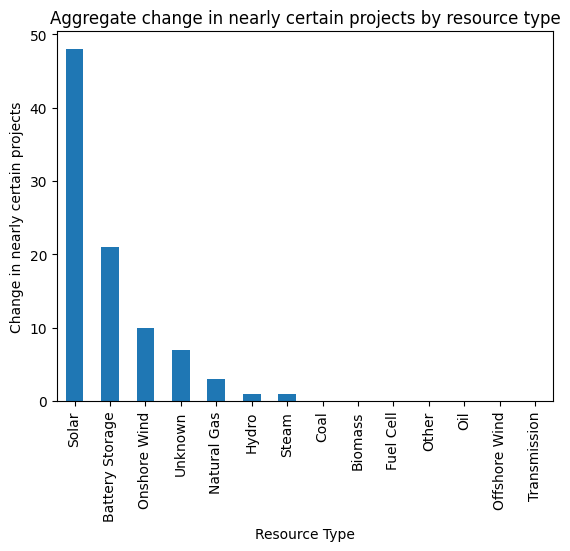

In [47]:
ax = change_certainty.groupby('resource_clean')['change_certainty'].sum().reset_index().sort_values('change_certainty', ascending = False).plot.bar(x = "resource_clean", legend = False, title = "Aggregate change in nearly certain projects by resource type", xlabel="Resource Type", ylabel="Change in nearly certain projects")
ax.axhline(y=0, xmin=-1, xmax=1, color='grey', linestyle='-', lw=0.4)

In [48]:
change_certainty_filt = change_certainty_sp.groupby('resource_clean').filter(lambda x: (x['change_certainty'] != 0).any()).reset_index() 
resources = change_certainty_filt.resource_clean.unique()
change_certainty_filt['change_certainty'] = change_certainty_filt['change_certainty'].astype(int)

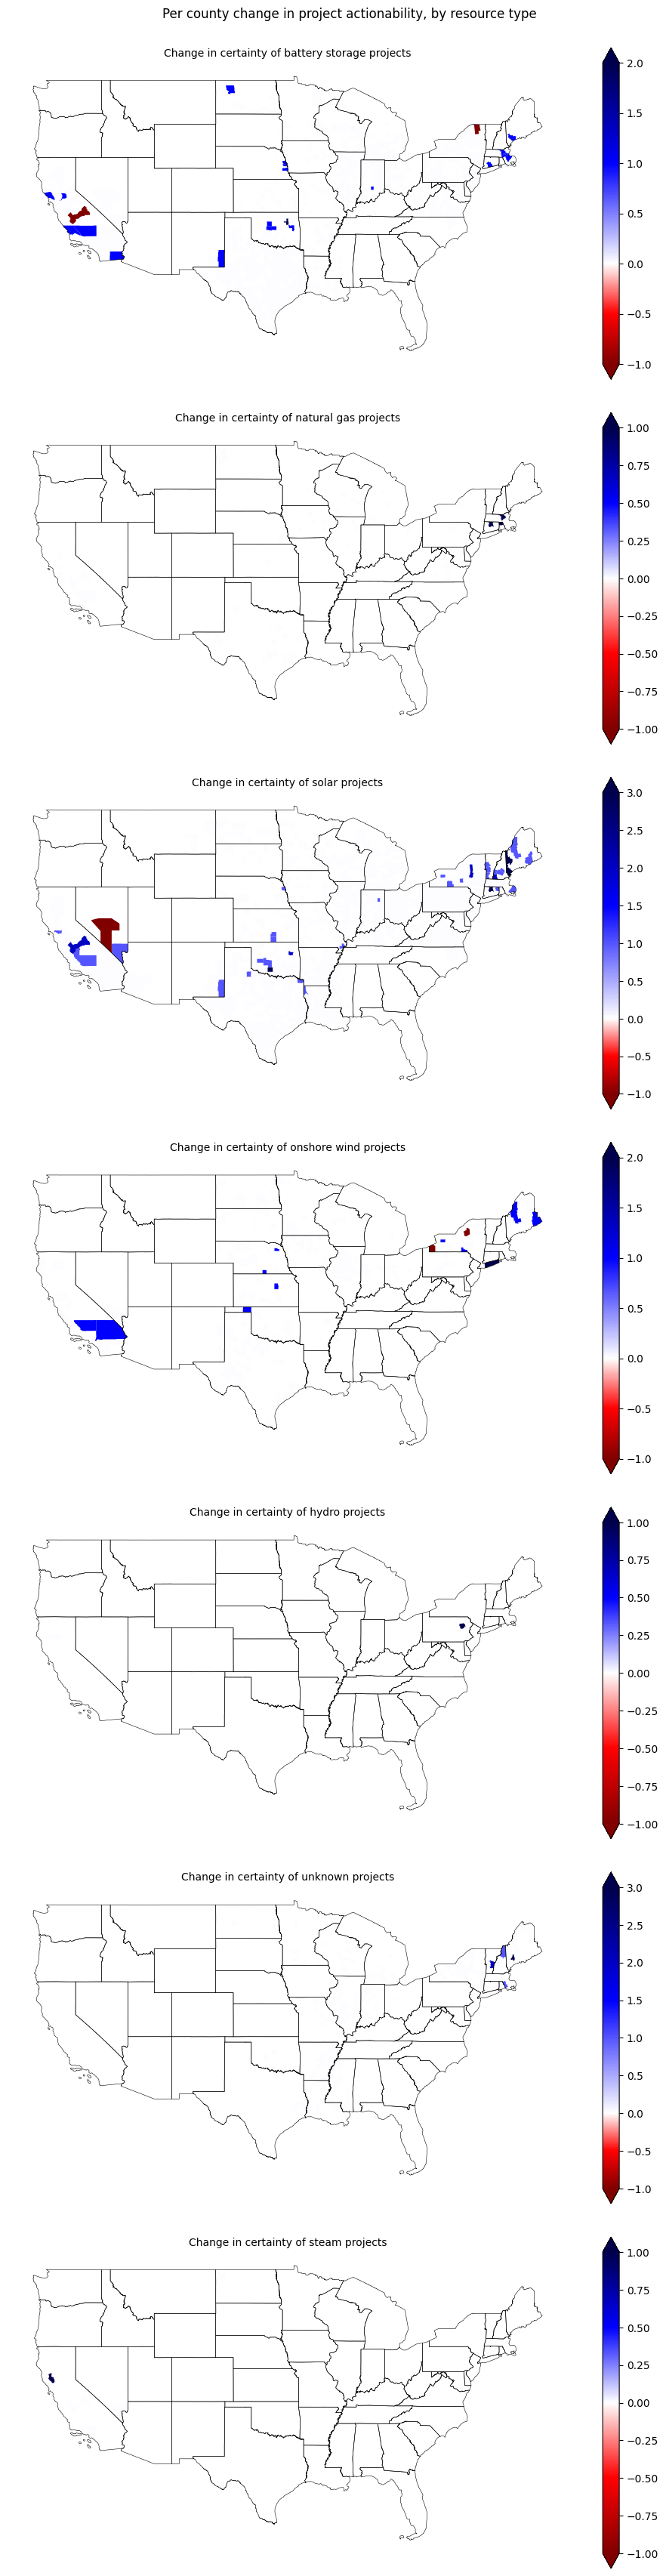

In [49]:
fig, ax = plot.subplots(len(resources), 1, figsize = (10, 35))
fig.suptitle("Per county change in project actionability, by resource type", ha="center")
fig.tight_layout(rect=[0, 0, 1, 0.98]) # Make room for suptitle
for i, resource in enumerate(resources):
    resource_slice = change_certainty_filt[change_certainty_filt.resource_clean==resource]
    if any(resource_slice.change_certainty!=0): # If any change in category
        vmin = resource_slice.change_certainty.min() if resource_slice.change_certainty.min() < 0 else -1 # If no projects lost, set to -1
        vmax = resource_slice.change_certainty.max() if resource_slice.change_certainty.max() > 0 else 1 # If no projects gained, set to 1
        norm = matplotlib.colors.TwoSlopeNorm(vmin = vmin, vcenter=0, vmax=vmax)
        resource_slice.plot(ax = ax[i], column="change_certainty", cmap = "seismic_r", norm = norm, legend = True, legend_kwds={"extend":"both"}) # To update
        state_plot.boundary.plot(ax = ax[i], edgecolor="black", linewidth = 0.4)
        ax[i].set_title(f"Change in certainty of {resource.lower()} projects", size = 10)
        ax[i].set_axis_off()
        cb_ax = fig.axes[i+len(resources)] # Get colorbar
        cb_ax.set_yscale('linear') # Set to be linear
        